# Summarize delay between collection and submission dates

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gamma, nbinom

%matplotlib inline

In [2]:
sns.set_style("ticks")

In [3]:
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.facecolor"] = "white"

In [4]:
metadata_path = "../data/natural/h3n2/metadata.tsv"

figure_path = "../results/figures/distribution_of_delays.pdf"

## Prepare metadata

In [5]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t"
)

In [6]:
metadata.head()

,strain,virus,segment,accession,date,date_submitted,region,country,division,location,passage_category,originating_lab,submitting_lab,age,gender
0,A/Slovenia/712/2014,flu,ha,EPI536402,2014-02-19,2014-07-22,Europe,Slovenia,Slovenia,Slovenia,cell,"Laboratory For Virology, National Institute Of...",National Institute For Medical Research,?,female
1,A/Saskatchewan/RV0847/2017,flu,ha,EPI1005605,2017-02-06,2017-06-05,North America,Canada,Saskatchewan,Saskatchewan,undetermined,?,Public Health Agency Of Canada (phac),85y,female
2,A/Pennsylvania/114/2017,flu,ha,EPI1128260,2017-01-24,2017-12-21,North America,Usa,Pennsylvania,Pennsylvania,unpassaged,Children's Hospital Of Pittsburgh Upmc,Centers For Disease Control And Prevention,69y,male
3,A/Perth/1001/2018,flu,ha,EPI1269286,2018-06-07,2018-08-14,Oceania,Australia,Western Australia,Perth,cell,Institute Of Medical And Veterinary Science (i...,Who Collaborating Centre For Reference And Res...,85y,female
4,A/Mexico/INCMNSZ-BMR287/2020,flu,ha,EPI1806875,2020-01-22,2020-10-22,North America,Mexico,Mexico,Mexico,unpassaged,Instituto Nacional De Enfermedades Respiratorias,Instituto Nacional De Ciencias Medicas Y Nutri...,?,?


In [7]:
metadata[pd.isnull(metadata["date_submitted"])]

,strain,virus,segment,accession,date,date_submitted,region,country,division,location,passage_category,originating_lab,submitting_lab,age,gender


In [8]:
sum(metadata["date_submitted"].str.contains("X"))

0

Drop records with ambiguous collection or submission dates. We need complete dates for both fields to calculate the distribution of the delay between collection and submission.

In [9]:
filtered_metadata = metadata[
    (~metadata["date"].str.contains("X")) &
    (metadata["date"] != "?") &
    (~metadata["date_submitted"].str.contains("X")) &
    (metadata["date_submitted"] != "?")
].copy()

In [10]:
metadata.shape

(113943, 15)

In [11]:
filtered_metadata.shape

(104392, 15)

Convert date fields into timestamps.

In [12]:
filtered_metadata["date"] = pd.to_datetime(filtered_metadata["date"])
filtered_metadata["date_submitted"] = pd.to_datetime(filtered_metadata["date_submitted"])

In [13]:
filtered_metadata.head()

,strain,virus,segment,accession,date,date_submitted,region,country,division,location,passage_category,originating_lab,submitting_lab,age,gender
0,A/Slovenia/712/2014,flu,ha,EPI536402,2014-02-19,2014-07-22,Europe,Slovenia,Slovenia,Slovenia,cell,"Laboratory For Virology, National Institute Of...",National Institute For Medical Research,?,female
1,A/Saskatchewan/RV0847/2017,flu,ha,EPI1005605,2017-02-06,2017-06-05,North America,Canada,Saskatchewan,Saskatchewan,undetermined,?,Public Health Agency Of Canada (phac),85y,female
2,A/Pennsylvania/114/2017,flu,ha,EPI1128260,2017-01-24,2017-12-21,North America,Usa,Pennsylvania,Pennsylvania,unpassaged,Children's Hospital Of Pittsburgh Upmc,Centers For Disease Control And Prevention,69y,male
3,A/Perth/1001/2018,flu,ha,EPI1269286,2018-06-07,2018-08-14,Oceania,Australia,Western Australia,Perth,cell,Institute Of Medical And Veterinary Science (i...,Who Collaborating Centre For Reference And Res...,85y,female
4,A/Mexico/INCMNSZ-BMR287/2020,flu,ha,EPI1806875,2020-01-22,2020-10-22,North America,Mexico,Mexico,Mexico,unpassaged,Instituto Nacional De Enfermedades Respiratorias,Instituto Nacional De Ciencias Medicas Y Nutri...,?,?


## Calculate and plot delay between collection and submission

In [14]:
filtered_metadata["submission_delay"] = filtered_metadata["date_submitted"] - filtered_metadata["date"]

In [15]:
filtered_metadata.head()

,strain,virus,segment,accession,date,date_submitted,region,country,division,location,passage_category,originating_lab,submitting_lab,age,gender,submission_delay
0,A/Slovenia/712/2014,flu,ha,EPI536402,2014-02-19,2014-07-22,Europe,Slovenia,Slovenia,Slovenia,cell,"Laboratory For Virology, National Institute Of...",National Institute For Medical Research,?,female,153 days
1,A/Saskatchewan/RV0847/2017,flu,ha,EPI1005605,2017-02-06,2017-06-05,North America,Canada,Saskatchewan,Saskatchewan,undetermined,?,Public Health Agency Of Canada (phac),85y,female,119 days
2,A/Pennsylvania/114/2017,flu,ha,EPI1128260,2017-01-24,2017-12-21,North America,Usa,Pennsylvania,Pennsylvania,unpassaged,Children's Hospital Of Pittsburgh Upmc,Centers For Disease Control And Prevention,69y,male,331 days
3,A/Perth/1001/2018,flu,ha,EPI1269286,2018-06-07,2018-08-14,Oceania,Australia,Western Australia,Perth,cell,Institute Of Medical And Veterinary Science (i...,Who Collaborating Centre For Reference And Res...,85y,female,68 days
4,A/Mexico/INCMNSZ-BMR287/2020,flu,ha,EPI1806875,2020-01-22,2020-10-22,North America,Mexico,Mexico,Mexico,unpassaged,Instituto Nacional De Enfermedades Respiratorias,Instituto Nacional De Ciencias Medicas Y Nutri...,?,?,274 days


In [16]:
filtered_metadata["submission_delay"].describe()

count                         104392
mean     303 days 00:58:44.959767032
std      866 days 11:42:04.792754080
min                  0 days 00:00:00
25%                 47 days 00:00:00
50%                 85 days 00:00:00
75%                173 days 00:00:00
max              42575 days 00:00:00
Name: submission_delay, dtype: object

In [17]:
filtered_metadata["submission_delay"].describe()

count                         104392
mean     303 days 00:58:44.959767032
std      866 days 11:42:04.792754080
min                  0 days 00:00:00
25%                 47 days 00:00:00
50%                 85 days 00:00:00
75%                173 days 00:00:00
max              42575 days 00:00:00
Name: submission_delay, dtype: object

In [18]:
delay_in_days = filtered_metadata["submission_delay"].dt.days.values

In [19]:
bins = np.linspace(
    0,
    delay_in_days.max(),
    100
)

Text(0, 0.5, 'Number of strains')

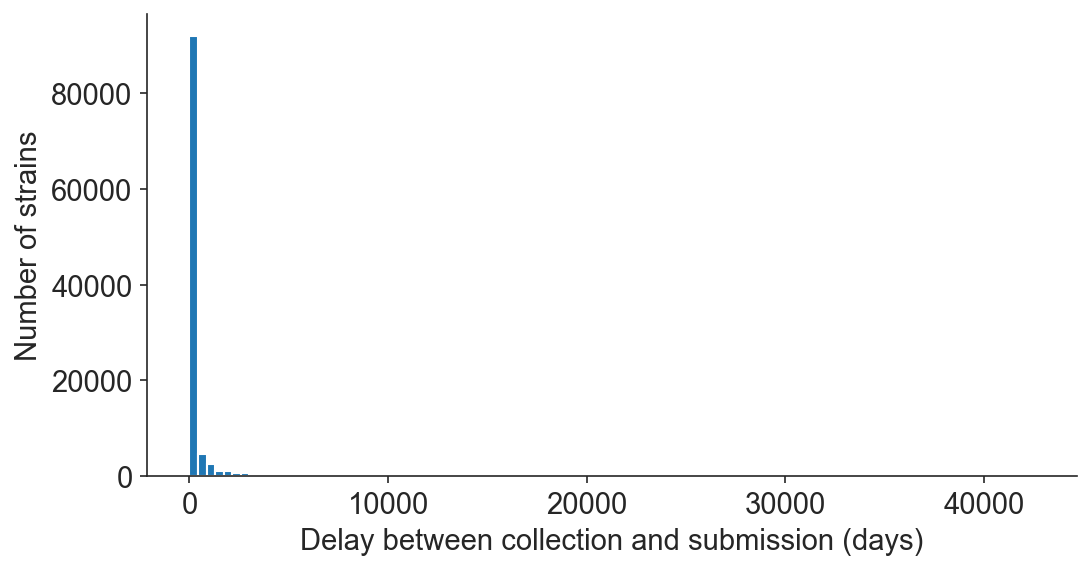

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
values, hist_bins, patches = ax.hist(delay_in_days, bins=bins)
ax.set_xlabel("Delay between collection and submission (days)")
ax.set_ylabel("Number of strains")

To understand how the delay between collection and submission changed over time, we inspect the distribution in sliding windows that match our original forecasting analysis (6 year windows, sliding by 6 months).

In [21]:
end_dates = pd.date_range(
    "2006-01-01",
    "2020-01-01",
    freq="6MS"
)

In [22]:
years_back = pd.DateOffset(years=6)

In [23]:
end_dates.shape

(29,)

In [24]:
delay_in_days.max()

42575

In [25]:
delay_in_days = filtered_metadata["submission_delay"].dt.days.values

In [26]:
bins = np.arange(0, 1000, 30)

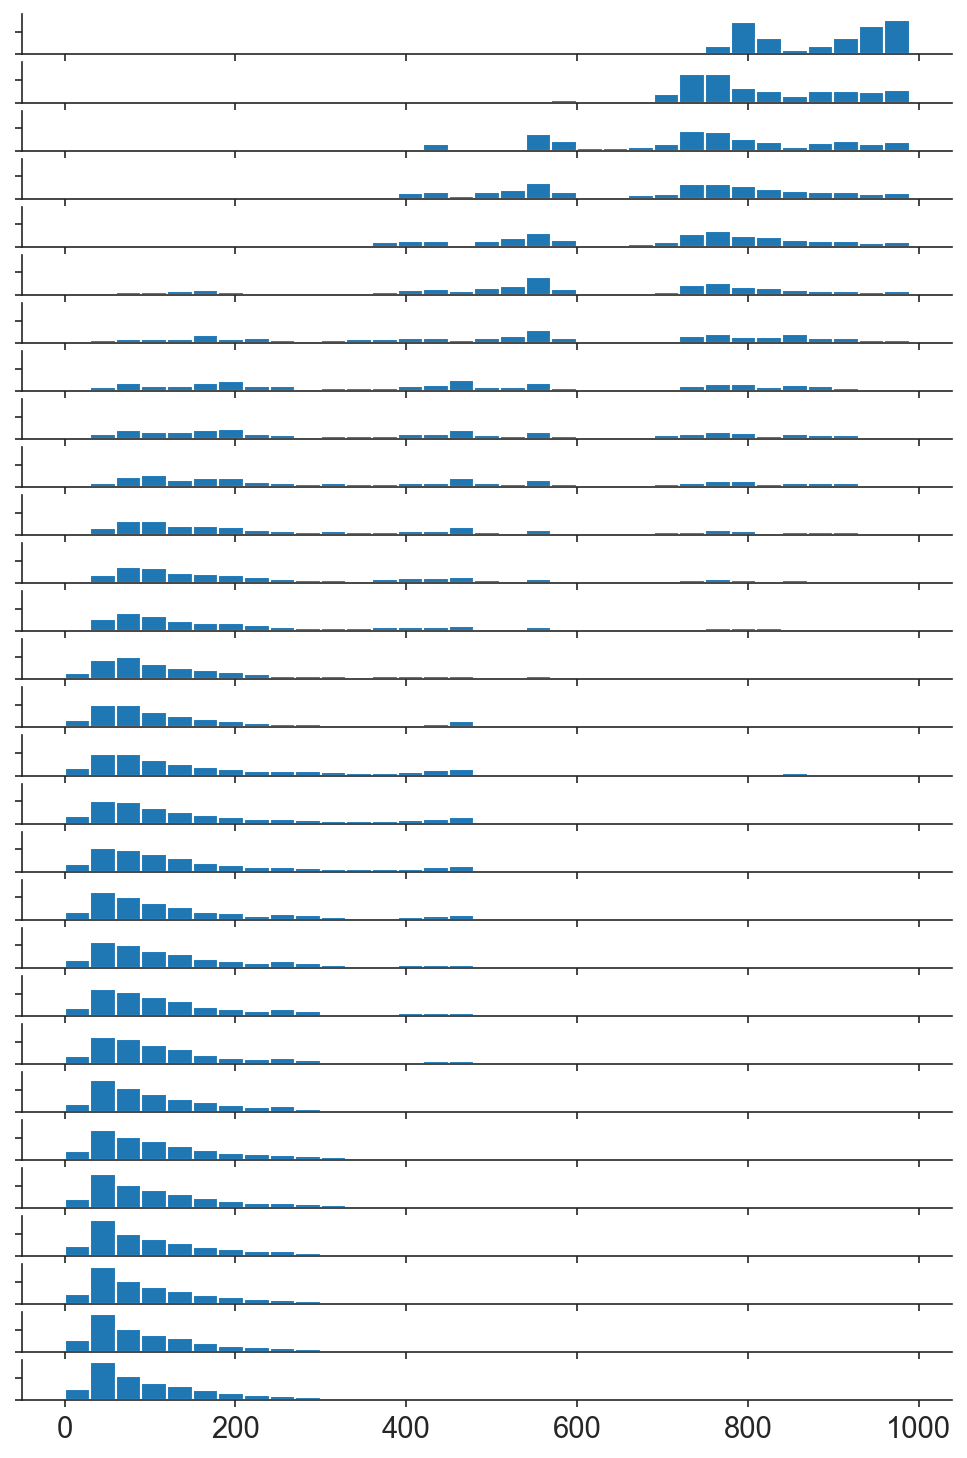

In [27]:
start_dates = []
mean_delays = []
std_delays = []

fig, axes = plt.subplots(
    nrows=end_dates.shape[0],
    ncols=1,
    figsize=(8, 12),
    sharex=True,
    sharey=True
)

for end_date, ax in zip(end_dates, axes.flatten()):
    start_date = end_date - years_back
    window_metadata = filtered_metadata[
        (filtered_metadata["date"] >= start_date) &
        (filtered_metadata["date"] < end_date)
    ]
    window_delay_in_days = window_metadata["submission_delay"].dt.days.values
    
    start_dates.append(start_date)
    mean_delays.append(window_delay_in_days.mean())
    std_delays.append(window_delay_in_days.std())
    ax.hist(
        window_delay_in_days,
        bins=bins,
        density=True
    )
    ax.set_yticklabels([])

In [28]:
start_dates = pd.to_datetime(start_dates)

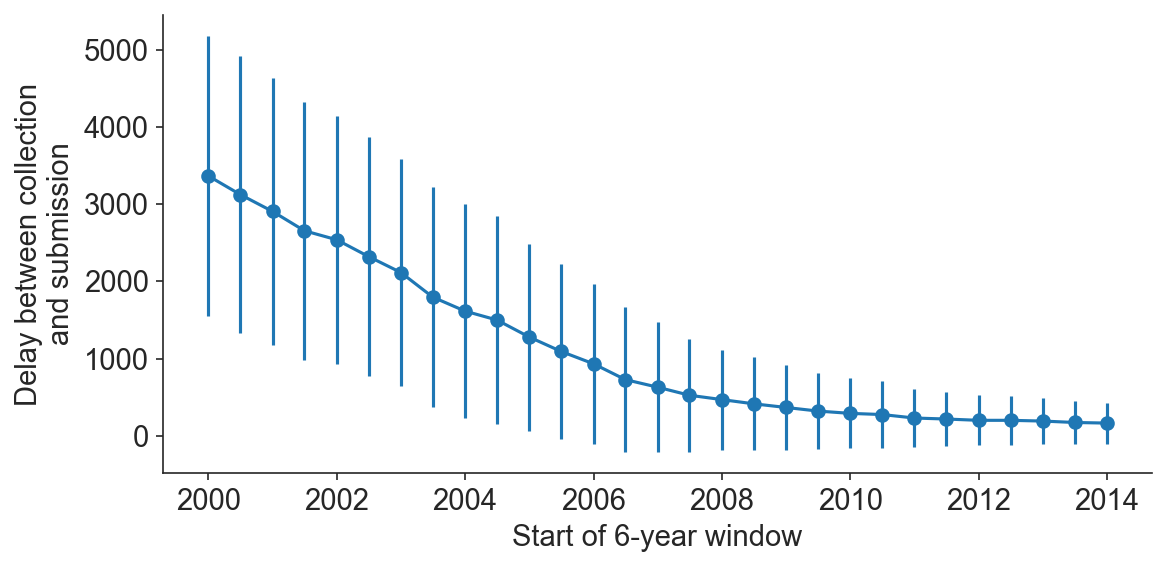

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.errorbar(
    start_dates,
    mean_delays,
    std_delays,
    marker="o",
    fmt=""
)
ax.set_xlabel("Start of 6-year window")
ax.set_ylabel("Delay between collection\nand submission")

plt.tight_layout()

## Investigate distribution of delays in the last complete year

Filter records to those from the last year. These should have more reasonable and consistent submission delays.

In [30]:
recent_metadata = filtered_metadata[
    (filtered_metadata["date"] >= "2019-01-01") &
    (filtered_metadata["date"] < "2020-01-01")
].copy()

In [31]:
filtered_metadata.shape

(104392, 16)

In [32]:
recent_metadata.shape

(11315, 16)

In [33]:
filtered_metadata.shape[0] - recent_metadata.shape[0]

93077

In [34]:
recent_metadata.shape[0] / filtered_metadata.shape[0]

0.1083895317648862

In [35]:
delay_in_days = recent_metadata["submission_delay"].dt.days.values

In [36]:
bins = np.arange(
    0,
    delay_in_days.max() + 1,
    30
)

Text(0, 0.5, 'Number of strains')

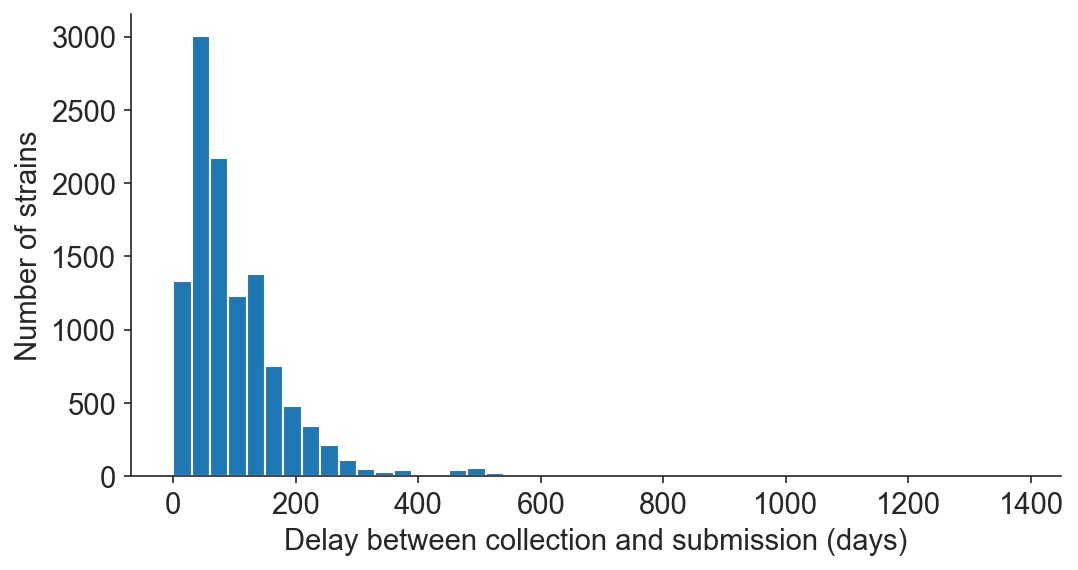

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
values, hist_bins, patches = ax.hist(delay_in_days, bins=bins)
ax.set_xlabel("Delay between collection and submission (days)")
ax.set_ylabel("Number of strains")

In [38]:
delay_in_days.mean()

102.42624834290764

In [39]:
delay_in_days.min()

4

In [40]:
(delay_in_days <= 31).sum()

1576

In [41]:
delay_in_days.shape

(11315,)

In [42]:
(delay_in_days <= 31).sum() / delay_in_days.shape[0]

0.13928413610251877

In [43]:
(delay_in_days <= 62).sum()

4578

In [44]:
(delay_in_days <= 62).sum() / delay_in_days.shape[0]

0.40459566946531156

In [45]:
recent_metadata[recent_metadata["submission_delay"].dt.days > 100]["submitting_lab"].value_counts()

Centers For Disease Control And Prevention                                               1371
Who Collaborating Centre For Reference And Research On Influenza                          648
Microbiology Services Colindale, Public Health England                                    544
Crick Worldwide Influenza Centre                                                          443
B.c. Centre For Disease Control                                                           286
National Institute Of Infectious Diseases (niid)                                          184
Public Health Agency Of Canada (phac)                                                     176
Who Chinese National Influenza Center                                                     125
Ministry Of Health, Singapore                                                              67
Who National Influenza Centre Russian Federation                                           62
Instituto Oswaldo Cruz Fiocruz                              

Text(0, 0.5, 'Density')

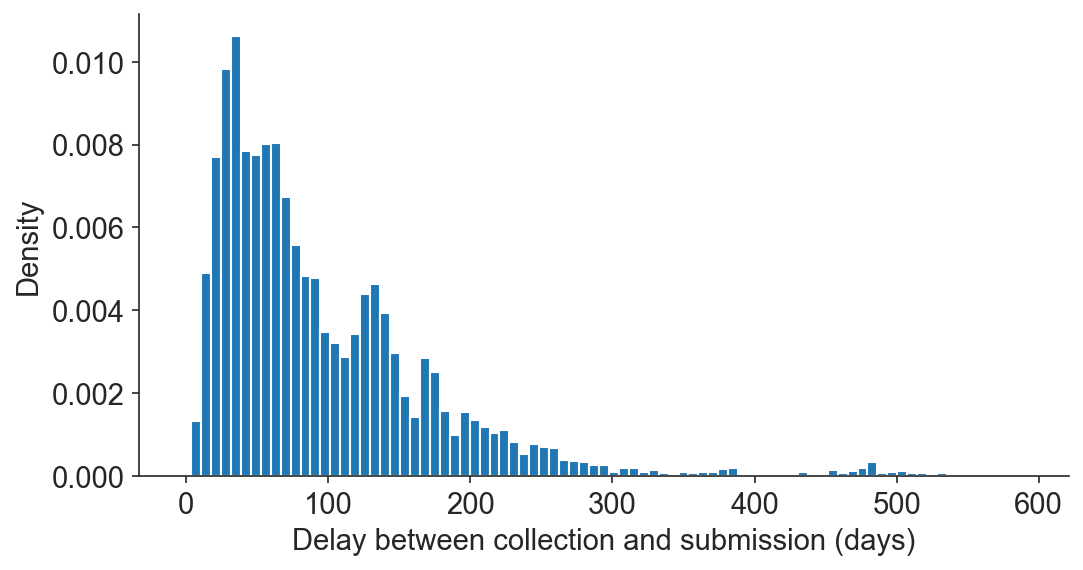

In [46]:
# Focus bins where the majority of samples occur (<600 days of delay).
bins = np.arange(
    0,
    600,
    7
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
values, hist_bins, patches = ax.hist(delay_in_days, bins=bins, density=True, align="left")
ax.set_xlabel("Delay between collection and submission (days)")
ax.set_ylabel("Density")

In [47]:
(delay_in_days > 600).sum()

37

## Find a gamma distribution that matches the empirical distribution

Find gamma distribution parameters that best correspond to the observed delay in days for the last year using maximum likelihood estimation.

In [48]:
shape, loc, scale = gamma.fit(delay_in_days)

In [49]:
shape

1.5980522182276626

In [50]:
loc

3.98226755466691

In [51]:
scale

61.560434766916785

Generate and plot random values from the gamma distribution matching the MLE parameters from the empirical distribution.

In [56]:
gamma_data = gamma.rvs(
    a=shape,
    loc=loc,
    scale=scale,
    size=delay_in_days.shape[0]
)

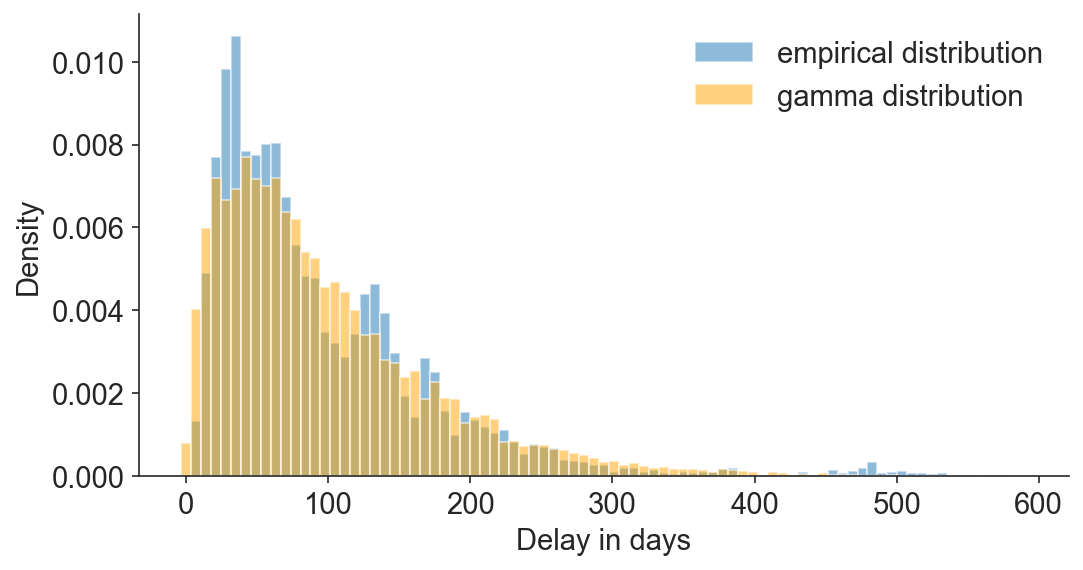

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Focus bins where the majority of samples occur (<600 days of delay).
bins = np.arange(
    0,
    600,
    7
)

values, hist_bins, patches = ax.hist(
    delay_in_days,
    bins=bins,
    density=True,
    align="left",
    alpha=0.5,
    label="empirical distribution"
)
values, hist_bins, patches = ax.hist(
    gamma_data,
    bins=bins,
    density=True,
    align="left",
    color="orange",
    alpha=0.5,
    label="gamma distribution"
)

ax.set_xlabel("Delay in days")
ax.set_ylabel("Density")
ax.legend(
    frameon=False
)

Text(0, 0.5, 'Random delay in days from gamma')

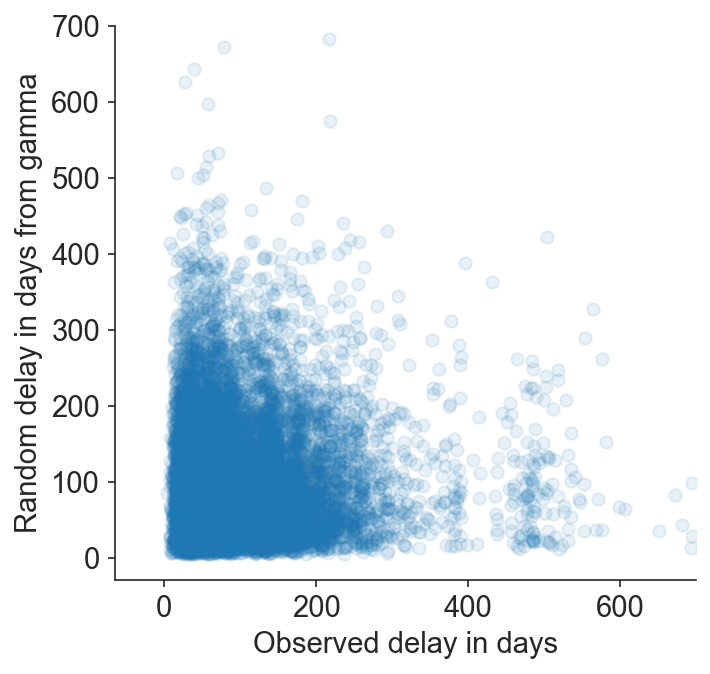

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(
    delay_in_days,
    gamma_data,
    "o",
    alpha=0.1,
)

ax.set_xlim(right=700)
ax.set_ylim(top=700)

ax.set_aspect("equal")
ax.set_xlabel("Observed delay in days")
ax.set_ylabel("Random delay in days from gamma")

Text(0, 0.5, 'Samples')

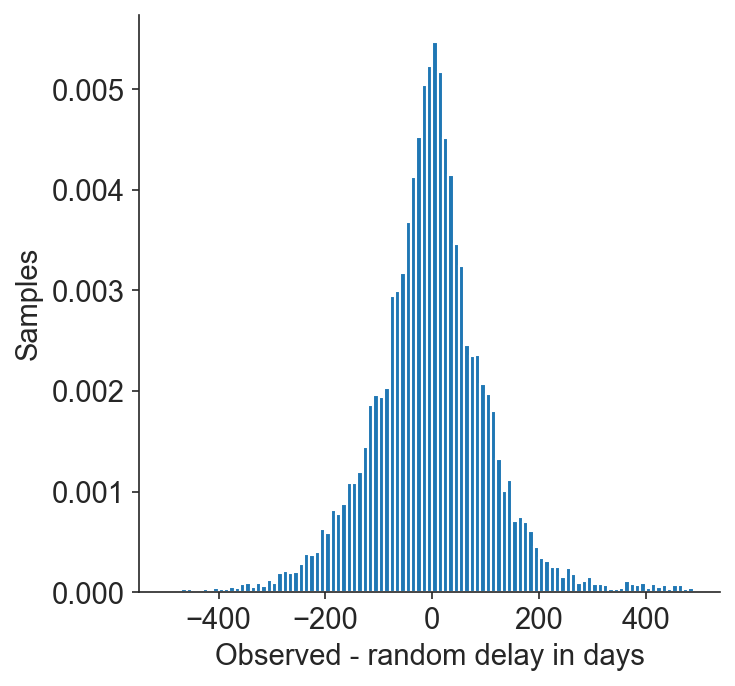

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.hist(
    delay_in_days - gamma_data,
    density=True,
    bins=np.arange(-500, 500, 10)
)

ax.set_xlabel("Observed - random delay in days")
ax.set_ylabel("Samples")

In [60]:
random_delay_in_days = np.random.choice(delay_in_days, size=delay_in_days.shape[0], replace=True)

Text(0, 0.5, 'Random delay in days from empirical')

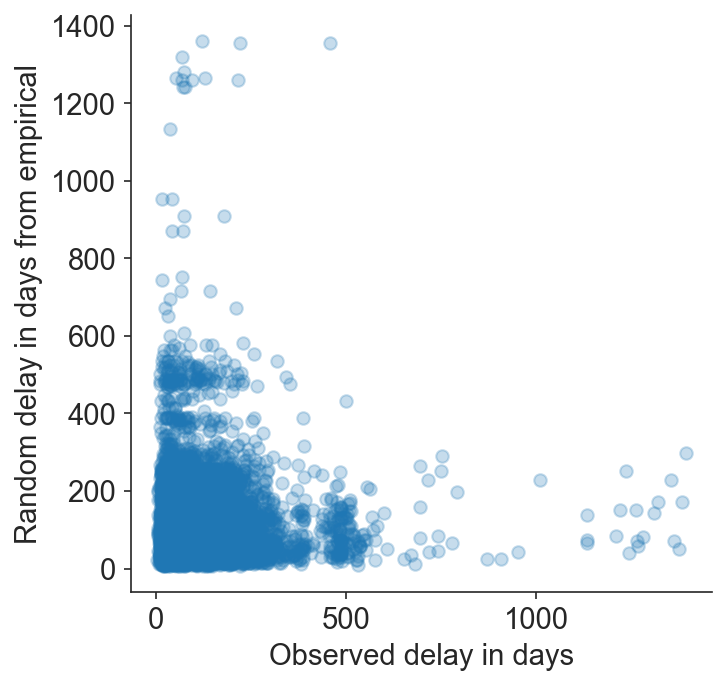

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(
    delay_in_days,
    random_delay_in_days,
    "o",
    alpha=0.25,
)

ax.set_xlabel("Observed delay in days")
ax.set_ylabel("Random delay in days from empirical")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(
    delay_in_days,
    gamma_data,
    "o",
    alpha=0.25,
)

ax.set_xlabel("Observed delay in days")
ax.set_ylabel("Random delay in days")

In [110]:
gamma_data.min()

4.224920626775664

In [111]:
gamma_data.mean()

102.8591449284431

In [112]:
delay_in_days.mean()

102.42624834290764

In [113]:
shape

1.5980522182276626

In [114]:
scale

61.560434766916785

In [115]:
shape * scale

98.3767893343307

In [116]:
loc

3.98226755466691

In [117]:
ideal_scale = scale / 3.0

In [118]:
ideal_scale

20.520144922305594

In [119]:
shape * ideal_scale

32.79226311144356

In [120]:
ideal_gamma_data = gamma.rvs(
    a=shape,
    loc=loc,
    scale=ideal_scale,
    size=delay_in_days.shape[0]
)

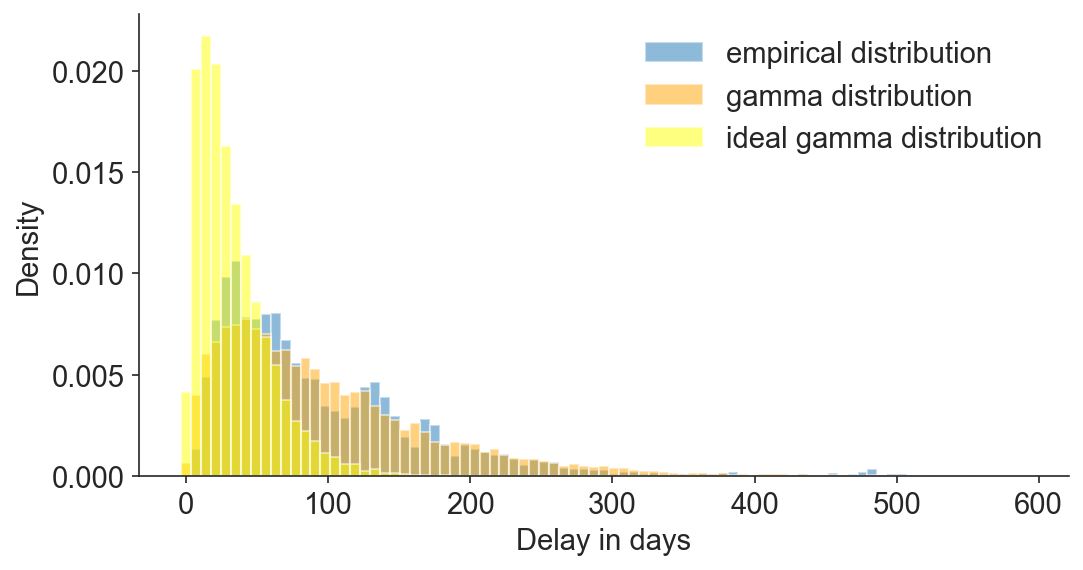

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
values, hist_bins, patches = ax.hist(
    delay_in_days,
    bins=bins,
    density=True,
    align="left",
    alpha=0.5,
    label="empirical distribution"
)

values, hist_bins, patches = ax.hist(
    gamma_data,
    bins=bins,
    density=True,
    align="left",
    color="orange",
    alpha=0.5,
    label="gamma distribution"
)

values, hist_bins, patches = ax.hist(
    ideal_gamma_data,
    bins=bins,
    density=True,
    align="left",
    color="yellow",
    alpha=0.5,
    label="ideal gamma distribution"
)

ax.set_xlabel("Delay in days")
ax.set_ylabel("Density")
ax.legend(
    frameon=False
)

In [122]:
ideal_gamma_data.min()

4.026972002899174

In [123]:
ideal_shape = shape / 3.0

In [124]:
ideal_shape

0.5326840727425542

In [125]:
ideal_shape * scale

32.79226311144357

In [126]:
ideal_gamma_data_by_shape = gamma.rvs(
    a=ideal_shape,
    loc=loc,
    scale=scale,
    size=delay_in_days.shape[0]
)

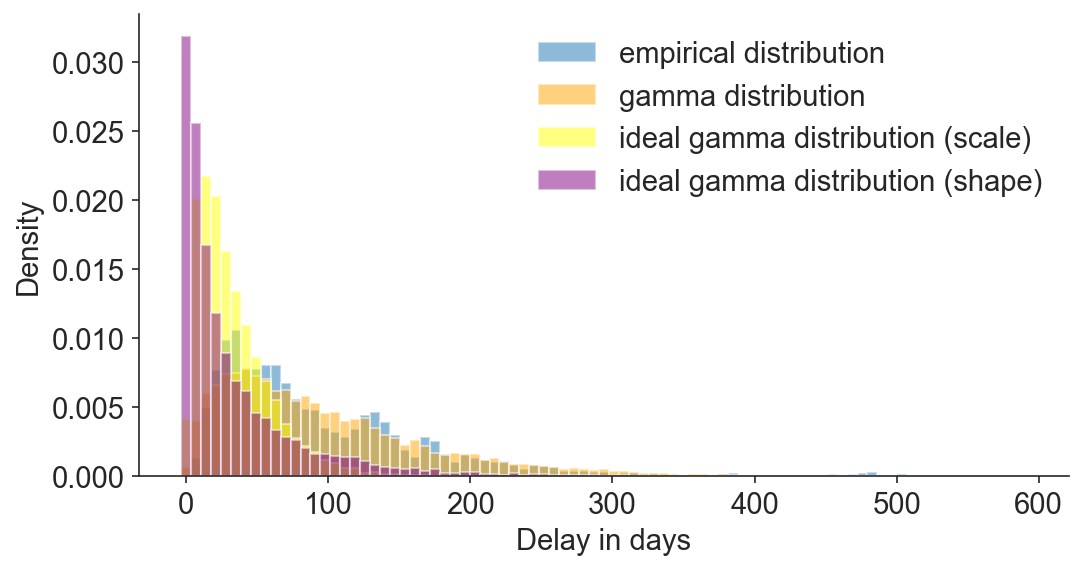

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
values, hist_bins, patches = ax.hist(
    delay_in_days,
    bins=bins,
    density=True,
    align="left",
    alpha=0.5,
    label="empirical distribution"
)

values, hist_bins, patches = ax.hist(
    gamma_data,
    bins=bins,
    density=True,
    align="left",
    color="orange",
    alpha=0.5,
    label="gamma distribution"
)

values, hist_bins, patches = ax.hist(
    ideal_gamma_data,
    bins=bins,
    density=True,
    align="left",
    color="yellow",
    alpha=0.5,
    label="ideal gamma distribution (scale)"
)

values, hist_bins, patches = ax.hist(
    ideal_gamma_data_by_shape,
    bins=bins,
    density=True,
    align="left",
    color="purple",
    alpha=0.5,
    label="ideal gamma distribution (shape)"
)


ax.set_xlabel("Delay in days")
ax.set_ylabel("Density")
ax.legend(
    frameon=False
)

In [128]:
ideal_gamma_data_by_shape.min()

3.9822680178563226

In [129]:
(ideal_gamma_data < 31).sum() / ideal_gamma_data.shape[0]

0.5160406539991163

In [130]:
(ideal_gamma_data < 62).sum() / ideal_gamma_data.shape[0]

0.8494918250110473

In [131]:
(ideal_gamma_data_by_shape < 31).sum() / ideal_gamma_data_by_shape.shape[0]

0.6308440123729563

In [132]:
(ideal_gamma_data_by_shape < 62).sum() / ideal_gamma_data_by_shape.shape[0]

0.8133451171011931

In [133]:
ideal_gamma_data.mean()

36.810741714641246

In [134]:
ideal_gamma_data_by_shape.mean()

37.52151482915502

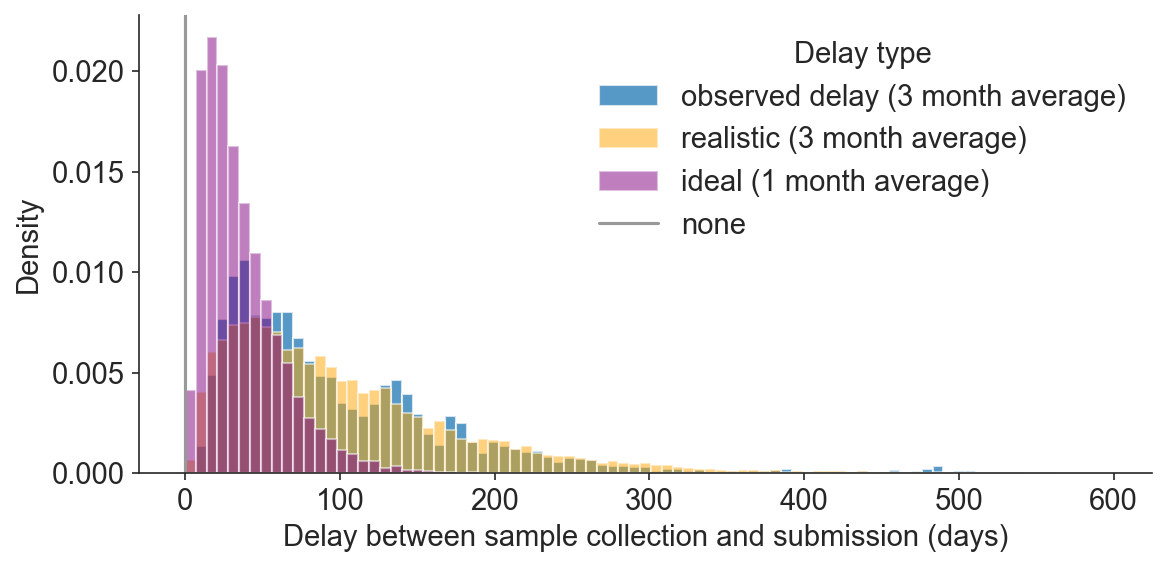

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
values, hist_bins, patches = ax.hist(
    delay_in_days,
    bins=bins,
    density=True,
    alpha=0.75,
    label="observed delay (3 month average)"
)

values, hist_bins, patches = ax.hist(
    gamma_data,
    bins=bins,
    density=True,
    color="orange",
    alpha=0.5,
    label="realistic (3 month average)"
)

values, hist_bins, patches = ax.hist(
    ideal_gamma_data,
    bins=bins,
    density=True,
    color="purple",
    alpha=0.5,
    label="ideal (1 month average)"
)

ax.axvline(
    x=0,
    color="#999999",
    label="none"
)

ax.set_xlabel("Delay between sample collection and submission (days)")
ax.set_ylabel("Density")
ax.legend(
    frameon=False,
    title="Delay type",
)

plt.tight_layout()
plt.savefig(figure_path)

## Find earliest submission date

In [144]:
filtered_metadata["date_submitted"].min()

Timestamp('2005-03-28 00:00:00')

In [145]:
filtered_metadata["date"].min()

Timestamp('1905-07-11 00:00:00')

In [146]:
filtered_metadata["date"].sort_values()

102238   1905-07-11
74382    1905-07-13
102358   1905-07-13
17948    1967-01-19
11711    1968-01-02
            ...    
10217    2023-04-03
23240    2023-04-03
47294    2023-04-03
5478     2023-04-04
40744    2023-04-04
Name: date, Length: 104392, dtype: datetime64[ns]